In [502]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases_v4 import *
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [503]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep2(X_size, layers):
    """
    Arguments:
    X_size -- входной размер для нейронки
    layers -- [(activation, размер_слоя), ...]
    
    activation: 'relu', 'sigmoid', 'relu_pow'
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(1)
    parameters = {}
    prev_size = X_size

    idx = 0
    for (activation, layer_dims) in layers:
        idx += 1
        parameters['W' + str(idx)] = np.random.randn(layer_dims, prev_size) / np.sqrt(prev_size)
        parameters['b' + str(idx)] = np.zeros((layer_dims, 1))
        prev_size = layer_dims
#         assert(parameters['W_' + str(idx)].shape == (layer_dims, prev_size))
#         assert(parameters['b_' + str(idx)].shape == (layer_dims, 1))

    idx = 0
    for (activation, layer_dims) in layers:
        idx += 1
        if activation == "relu_pow":
            parameters['k' + str(idx)] = np.full((layer_dims, 1), 1)
    
    return parameters

test_params = initialize_parameters_deep(10, [("relu", 5), ("relu_pow", 7), ("sigmoid", 1)])
test_params = {k: v.shape for k, v in test_params.items()}
print(test_params)

{'W_1': (5, 10), 'b_1': (5, 1), 'W_2': (7, 5), 'b_2': (7, 1), 'W_3': (1, 7), 'b_3': (1, 1), 'k_2': (7, 1)}


In [504]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
#     print(W.shape, A.shape)
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, k, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == "relu_pow":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu_pow(Z, k)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [505]:
def L_model_forward(X, layers, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(layers)
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(0, L):
        k = None
        W = parameters["W_" + str(l+1)]
        b = parameters["b_" + str(l+1)]
        if ("k_" + str(l+1)) in parameters: 
            k = parameters["k_" + str(l+1)]
        
#         print(A.shape, "x", W.shape, " => ", layers[l])
        A, cache = linear_activation_forward(A, W, b, k, layers[l][0])
        caches.append(cache)
    
#     # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
#     ### START CODE HERE ### (≈ 2 lines of code)
#     AL, cache = linear_activation_forward(A, 
#                                           parameters["W_" + str(L)], 
#                                           parameters["b_" + str(L)],
#                                           parameters["k_" + str(L)], 
#                                           layers[L][0])
#     caches.append(cache)
#     ### END CODE HERE ###
    
#     проверка количества примеров
    out_dims = layers[-1][1] # количество выходов
    assert(A.shape == (out_dims, X.shape[1]))
            
    return A, caches

In [506]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = - np.squeeze(np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1 - AL).T)) / m
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [507]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [508]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    dZ = None
    dk = None
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        ### END CODE HERE ###
        
    elif activation == "relu_pow":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ, dk = relu_pow_backward(dA, activation_cache)
        ### END CODE HERE ###
    
    assert(dZ is not None)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db, dk

In [509]:
def L_model_backward(AL, Y, caches, layers):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(layers) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    dAL = np.divide(1 - Y, 1 - AL) - np.divide(Y, AL)
    ### END CODE HERE ###
    
    last_dA = dAL
    for l in reversed(range(L)):
        activation = layers[l][0]
        prev_dA, dW, db, dk = linear_activation_backward(last_dA, caches[l], activation)

        grads["dW_" + str(l + 1)] = dW
        grads["db_" + str(l + 1)] = db
        if dk is not None:
            grads["dk_" + str(l + 1)] = dk
        last_dA = prev_dA

    return grads

In [510]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W_" + str(l)] = ... 
                  parameters["b_" + str(l)] = ...
    """
    
    for key in parameters:
        dKey = "d"+key
        if dKey in grads:
            parameters[key] -= learning_rate * grads[dKey]
            
    return parameters

In [511]:
def L_layer_model(X, Y, X_dev, Y_dev, layers, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    assert(X.shape[1] == Y.shape[1])
    assert(X_dev.shape[1] == Y_dev.shape[1])
    assert(layers[-1][1] == Y.shape[0])
    costs = []                         # keep track of cost
    costs_dev = []
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(X.shape[0], layers)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, layers, parameters)
        AL_dev, _ = L_model_forward(X_dev, layers, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        cost_dev = compute_cost(AL_dev, Y_dev)
        
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches, layers)
#         print(grads)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            costs_dev.append(cost_dev)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.plot(np.squeeze(costs_dev))
    plt.ylabel('cost_dev')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

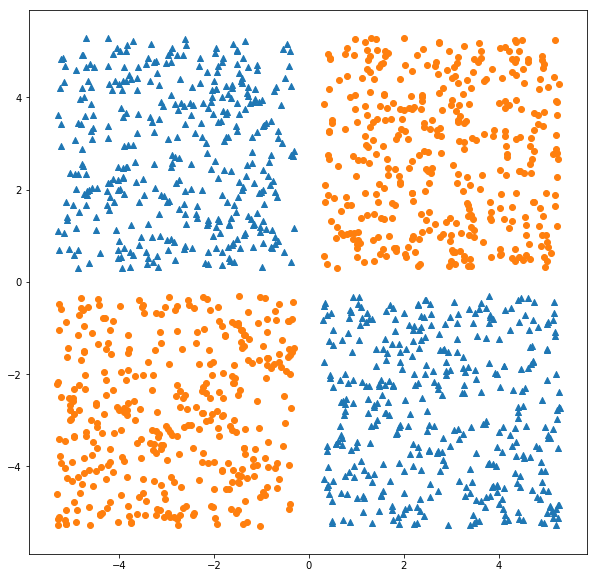

In [512]:
# def generateSpiral(radius, count):
#     a_class = []
#     b_class = []
#     for angle in range(0, np.pi * 3.5):



def data_spiral(num_samples, noise):
        """
        Generates the spiral dataset with the given number of samples and noise
        :param num_samples: total number of samples
        :param noise: noise percentage (0 .. 50)
        :return: None
        """
#         noise *= 0.01
        half = num_samples // 2
        points = np.zeros([num_samples, 2])
        labels = np.zeros((num_samples, 1)).astype(int)
        
        for j in range(num_samples):
            i = j % half
            label = 1
            delta = 0
            if j >= half:  # negative examples
                label = 0
                delta = np.pi
            r = i / half * 5 + np.random.normal(0, noise)
            t = (1.75 * i / half * 2 * np.pi + delta + np.random.normal(0, noise))
            
            x = r * np.sin(t) #+ np.random.normal(loc = 0, scale= noise) #random.uniform(-1, 1) * noise
            y = r * np.cos(t) #+ np.random.normal(loc = 0, scale= noise) #random.uniform(-1, 1) * noise
            labels[j] = label
            points[j] = (x, y)
        return points, labels
    
def data_xor(num_samples, noise):
        """
        Generates the xor (checker) dataset with the given number of samples and noise
        :param num_samples: total number of samples
        :param noise: noise percentage (0 .. 50)
        :return: None
        """
        def get_xor_label(px, py):
            return 1 if px * py >= 0 else 0

        noise *= 0.01
        points = np.zeros([num_samples, 2])
        labels = np.zeros([num_samples,1]).astype(int)
        for i in range(num_samples):
            x = random.uniform(-5, 5)
            padding = 0.3
            x += padding if x > 0 else -padding
            y = random.uniform(-5, 5)
            y += padding if y > 0 else -padding
            noise_x = random.uniform(-5, 5) * noise
            noise_y = random.uniform(-5, 5) * noise
            labels[i] = get_xor_label(x + noise_x, y + noise_y)
            points[i] = (x, y)
        return points, labels

def separateDots(points, labels):
    a_dots = []
    b_dots = []
    for i in range(len(points)):
        if labels[i] > 0:
            b_dots.append(points[i])
        else:
            a_dots.append(points[i])
    return np.array(a_dots), np.array(b_dots)


random.seed(1)
points, labels = data_xor(1500, 0.2)
points_1, points_2 = separateDots(points, labels)

plt.figure(figsize=(10, 10))


plt.scatter(points_1[:, 0], points_1[:, 1], marker='^')
plt.scatter(points_2[:, 0], points_2[:, 1], marker='o')
plt.show()
# print(points_2)

# np.random.normal(loc = 0, scale= 0.1)

In [513]:
model = [("relu", 5), ("relu", 4), ("sigmoid", 1)]
X = points.T
Y = labels.T
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
# L_layer_model()

X.shape =  (2, 1500)
Y.shape =  (1, 1500)


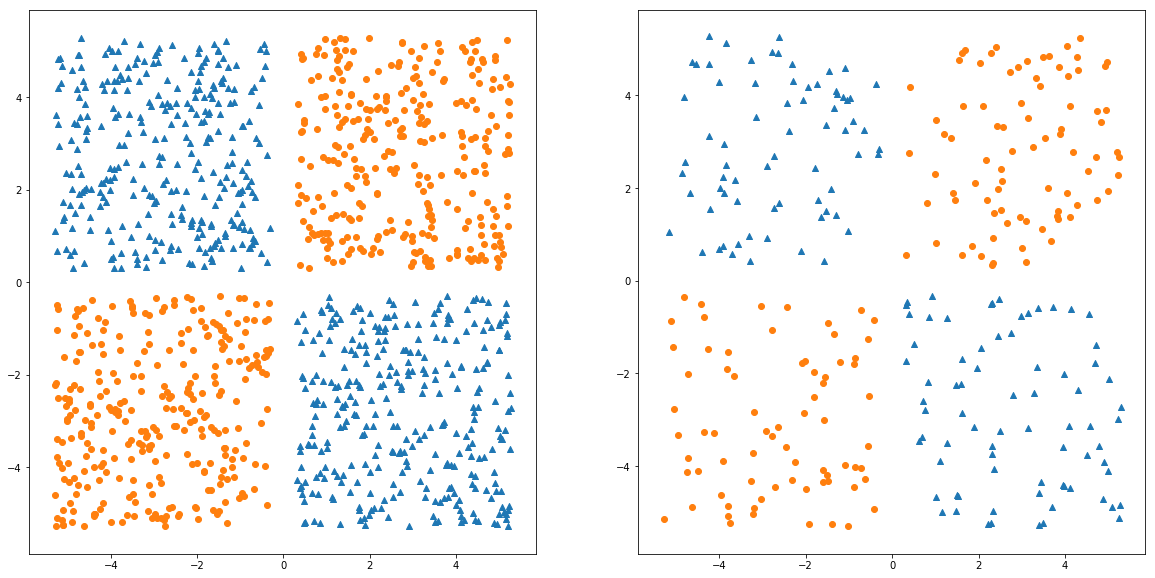

In [514]:
def unison_shuffled_copies(a, b):
    assert a.shape[1] == b.shape[1]
    p = np.random.permutation(a.shape[1])
    return a[:, p], b[:, p]

def split(X, percent):
    val = int(X.shape[1] * percent)
    temp = X[:,:val], X[:,val:]
    return temp

X, Y = unison_shuffled_copies(X, Y)
X, X_dev = split(X, 0.8)
Y, Y_dev = split(Y, 0.8)


plt.figure(figsize=(20, 10))
plt.subplot(121)
points_1, points_2 = separateDots(X.T, Y.T)
plt.scatter(points_1[:, 0], points_1[:, 1], marker='^')
plt.scatter(points_2[:, 0], points_2[:, 1], marker='o')

plt.subplot(122)
points_1, points_2 = separateDots(X_dev.T, Y_dev.T)
plt.scatter(points_1[:, 0], points_1[:, 1], marker='^')
plt.scatter(points_2[:, 0], points_2[:, 1], marker='o')

plt.show()

(1, 300)
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.693059
Cost after iteration 200: 0.693026
Cost after iteration 300: 0.693015
Cost after iteration 400: 0.693010
Cost after iteration 500: 0.693009
Cost after iteration 600: 0.693008
Cost after iteration 700: 0.693008
Cost after iteration 800: 0.693008
Cost after iteration 900: 0.693008
Cost after iteration 1000: 0.693008
Cost after iteration 1100: 0.693007
Cost after iteration 1200: 0.693007
Cost after iteration 1300: 0.693007
Cost after iteration 1400: 0.693007
Cost after iteration 1500: 0.693007
Cost after iteration 1600: 0.693007
Cost after iteration 1700: 0.693007
Cost after iteration 1800: 0.693007
Cost after iteration 1900: 0.693007
Cost after iteration 2000: 0.693007
Cost after iteration 2100: 0.693007
Cost after iteration 2200: 0.693007
Cost after iteration 2300: 0.693007
Cost after iteration 2400: 0.693007
Cost after iteration 2500: 0.693007
Cost after iteration 2600: 0.693007
Cost after iteration 2700: 0.69

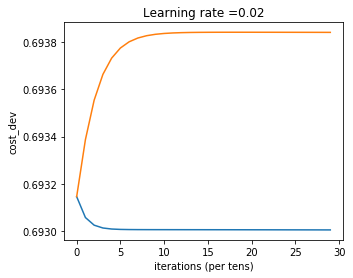

In [515]:
print(Y_dev.shape)
np.random.seed(3)
params = L_layer_model(X, Y, X_dev, Y_dev, model, print_cost=True, learning_rate= 0.02, num_iterations = 3000)

(2, 2500)


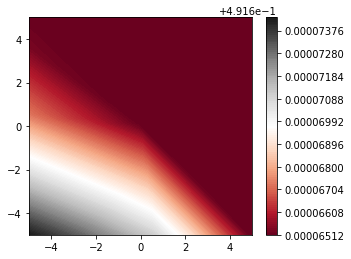

In [516]:
xi = np.linspace(-5, 5, 50)
yi = np.linspace(-5, 5, 50)

xx, yy = np.meshgrid(xi, yi)

def process_space(xx, yy, layers, parameters):
    temp = np.vstack((xx.reshape(1,-1), yy.reshape(1,-1)))
    res, _ = L_model_forward(temp, layers, parameters)
    return res.reshape(xx.shape)

zz = process_space(xx, yy, model, params)
print(test.shape)

plt.contourf(xx, yy, zz, 120, cmap='RdGy')
plt.colorbar();
plt.show()
# Z = f(X, Y)